In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
from scipy.optimize import Bounds
from scipy.optimize import LinearConstraint
from scipy.optimize import NonlinearConstraint
from scipy.optimize import SR1, BFGS
from scipy.optimize import minimize

In [3]:
data= pd.read_pickle("IHDP.zip")

In [4]:
arr = np.array(data)

In [5]:
fullT = arr[:,0]

In [6]:
p_ind = fullT == 0
q_ind = fullT == 1

In [7]:
fullX = arr[:, 5:]

In [8]:
N = len(fullX)

In [9]:
Xp = fullX[p_ind]
Xq = fullX[q_ind]

In [10]:
Np = len(Xp)
Nq = len(Xq)

# Kernel Optimal Weighting

In [11]:
def gauss_kernel(x1, x2):
    return np.exp(-0.5*np.linalg.norm(x1-x2)**2)

In [12]:
fullK = np.array([[gauss_kernel(x1,x2) for x1 in fullX] for x2 in fullX])

In [13]:
Kpp = np.array([[gauss_kernel(x1,x2) for x1 in Xp] for x2 in Xp])
Kqp = np.array([[gauss_kernel(x1,x2) for x1 in Xp] for x2 in Xq])
Kqq = np.array([[gauss_kernel(x1,x2) for x1 in Xq] for x2 in Xq])

In [14]:
ep = np.ones(Np)/Np
eq = np.ones(Nq)/Nq

In [15]:
def mmd_sq(Kpp, Kqp, Kqq, ep, eq):
    return (ep @ Kpp @ ep) - 2*(eq @ Kqp @ ep) + (eq @ Kqq @ eq)

In [16]:
def mmd(Kpp, Kqp, Kqq, ep, eq):
    return np.sqrt(mmd_sq(Kpp,Kqp,Kqq,ep,eq))

## Primal Problem

In [17]:
def mmd_balancing(Kpp,Kqp,Kqq, delta): 

    def objective(w):
        return ((w-1)**2).sum()
    
    def obj_jac(w):
        return 2*w - 1
    
    ep = np.ones(Np)/Np
    eq = np.ones(Nq)/Nq
    
    linear_constraint1 = LinearConstraint([[1/Np for _ in range(Np)]], [1], [1])

    def balance_constraint(w):
        return mmd_sq(Kpp,Kqp,Kqq,  w*ep,  eq)
    
    def bal_jac(w):
        return 2* (Kpp @ (w*ep)) *ep - 2*(eq@Kqp)*ep

    nonlinear_constraint = NonlinearConstraint(balance_constraint, 0, delta**2, jac=bal_jac)

    res = minimize(objective, x0=np.ones(Np), jac=obj_jac, constraints=[linear_constraint1, nonlinear_constraint])

    return res.x, balance_constraint(res.x), objective(res.x)

In [18]:
_, testbias, _ = mmd_balancing(Kpp,Kqp,Kqq, 0.0)
delta_min = np.sqrt(testbias)

delta_max = mmd(Kpp,Kqp,Kqq,ep,eq)
deltas = np.linspace(delta_min, delta_max, 20)

In [21]:
(delta_min, delta_max)

(0.0893775746871603, 0.10228585504108571)

## Dual Problem

In [22]:
e = np.ones(N)
Ip = np.diag(p_ind.astype(int))
Iq = np.diag(q_ind.astype(int))

In [23]:
def dual_problem(mu, eps): 

    def dual_objective(alpha):
        e = np.ones(N)
        f = alpha @ fullK
        Eq = (Iq @ (e/Nq)) 
        Ep = (Ip @ (e/Np))

        Eq_f = f @ Eq
        Ep_f = f @ Ep

        var_f = (f**2) @ Ep - (f @ Ep)**2
        #((f - Ep_f)**2) @ (Ip @ (e/Np))

        return -(Eq_f - Ep_f - (mu/4)*var_f)

    def dual_jac(alpha):
        e = np.ones(N)
        f = alpha @ fullK
        Eq = (Iq @ (e/Nq)) 
        Ep = (Ip @ (e/Np))

        return -(fullK @ Eq - fullK @ Ep - (mu/2) * fullK @ (f*Ep)  + (mu/2) * (f@Ep) * (fullK @ Ep))
    
    def rkhs_constraint(alpha):
        return alpha @ fullK @ alpha
    
    def rkhs_jac(alpha):
        return 2* fullK @ alpha
    nonlinear_constraint = NonlinearConstraint(rkhs_constraint, 0, eps, jac=rkhs_jac)
    
    x0 = np.random.uniform(-1,1,N)
    x0 /= x0.sum()
    res = minimize(dual_objective, x0=x0, jac=dual_jac, constraints=[nonlinear_constraint])

    return res

## run extreme mus and one in between

In [24]:
mus = np.linspace(1, 5000, 300)

mu_subset = [0, mus[10], mus[-1]]

In [25]:
mu_subset

[0, 168.19063545150502, 5000.0]

In [26]:
fs = []
ws = []
vs = []
bs = []
for mu in mu_subset:
    res = dual_problem(mu, 1) # 1 indicates unit norm ball in RKHS
    fstar = (res.x @ fullK)

    fstar_demean = fstar[p_ind] - fstar[p_ind].mean()

    weights = 1 + mu*fstar_demean/2

    variance = ((weights-1)**2).mean()
    bias = mmd(Kpp, Kqp, Kqq, weights/Np, eq)
    
    fs.append(fstar)
    ws.append(weights)
    vs.append(variance)
    bs.append(bias)

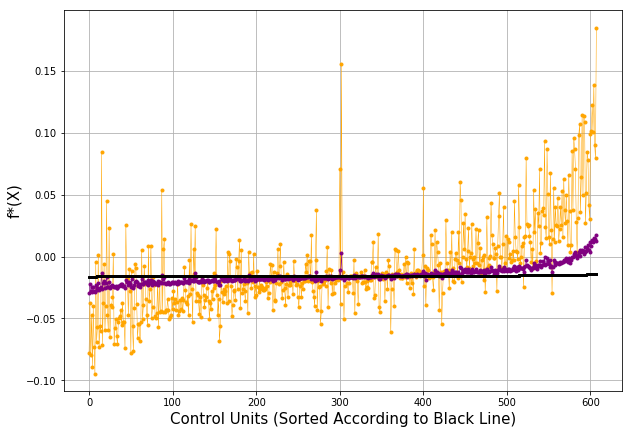

In [29]:
sort_order = np.argsort(fs[2][p_ind])

plt.figure(figsize=(10,7))

w = fs[0][p_ind]
plt.plot(range(len(w)),w[sort_order], color='orange', marker='o', linewidth=0.5, markersize=3)

# w = fs[0][p_ind]
# plt.plot(range(len(w)),w[sort_order], color='orange', marker='o', linewidth=0.5, markersize=3)

w = fs[1][p_ind]
plt.plot(range(len(w)),w[sort_order], color='purple', marker='o', linewidth=0.5, markersize=3)

# w = fs[-100][p_ind] 
# plt.plot(range(len(w)),w[sort_order], color='navy', marker='o', linewidth=0.5, markersize=2)

w = fs[2][p_ind] 
plt.plot(range(len(w)),w[sort_order], color='black', marker='s', linewidth=0.5, markersize=2.5)

plt.ylabel("f*(X)", fontsize=15)
plt.xlabel("Control Units (Sorted According to Black Line)", fontsize=15)

plt.grid()

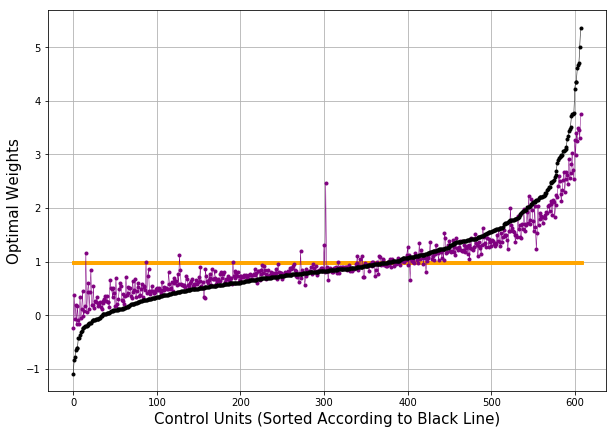

In [30]:
plt.figure(figsize=(10,7))

w = ws[0]
plt.plot(range(len(w)),w[sort_order], color='orange', marker='s', linewidth=0.5, markersize=3)

#plt.figure(figsize=(10,7))

w = ws[1]
plt.plot(range(len(w)),w[sort_order], color='purple', marker='o', linewidth=0.5, markersize=3)

#plt.figure(figsize=(10,7))

# w = ws[-100]
# plt.plot(range(len(w)),w[sort_order], color='navy', marker='o', linewidth=0.5, markersize=2)

w = ws[2]
plt.plot(range(len(w)),w[sort_order], color='black', marker='o', linewidth=0.5, markersize=3)

plt.ylabel("Optimal Weights", fontsize=15)
plt.xlabel("Control Units (Sorted According to Black Line)", fontsize=15)
plt.grid()

#### comparing sorting:

In [31]:
sort_order = np.argsort(fs[-1])
fullT[sort_order]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [32]:
sort_order = np.argsort(fs[0])
fullT[sort_order]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.